In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

In [134]:
louv = pd.read_csv('../results/networkClusters/louvain_small_clusters.txt', sep='\t', index_col=0)
rand = pd.read_csv('../results/sensitivityNetworkClusters/sensitivity_randscores.tsv', sep='\t')
rand.index=louv.index
rand.columns = louv.index.values

In [6]:
from umap import UMAP
import seaborn as sns
sns.set()

In [4]:
u = UMAP(metric='cosine', n_neighbors=5, min_dist=.01)
u_coords = u.fit_transform(rand.values)

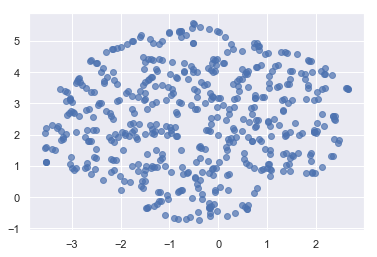

In [7]:
plt.scatter(u_coords[:, 0], u_coords[:, 1], alpha=0.7)
plt.show()

In [12]:
sns.set_style('ticks')

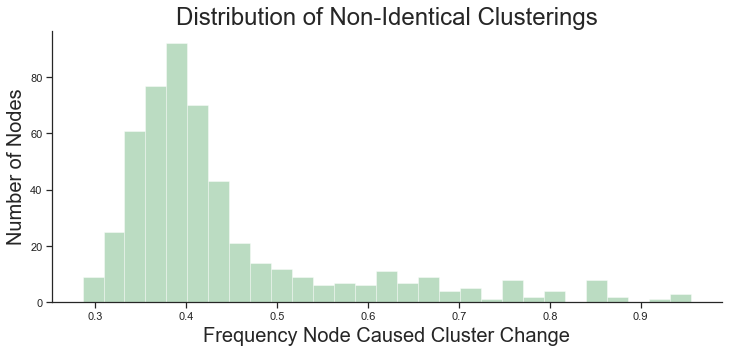

In [181]:
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(np.sum((rand != 1).values/517., axis=1), kde=False, color='g')
#ax.set_title('')
plt.title('Distribution of Non-Identical Clusterings', size=24)
plt.ylabel('Number of Nodes', size=20)
plt.xlabel('Frequency Node Caused Cluster Change', size=20) 
sns.despine()
plt.show()

In [128]:
mean_nonzero = np.mean(rand[rand !=1], axis=1)
nonzero_count = np.sum((rand != 1).values, axis=1)

In [129]:
network = pd.read_csv('../data/interactionNetworks/kin_anscombe_weighted.csv', sep='\t', header=None)
network.head()

,0,1,2
0,MST1R,YES1,1.224745
1,TYRO3,YES1,1.224745
2,FGR,SRC,2.345208
3,ATR,FLT1,1.224745
4,LYN,PRKCD,3.082207


In [130]:
nodelist = pd.DataFrame(pd.concat([network.iloc[:, 0], network.iloc[:, 1]], axis=0, ignore_index=True))
nodelist.columns = ['Node']
nodelist['Degree'] = ''
degree = nodelist.groupby('Node').agg(len)

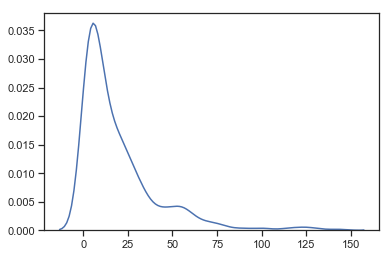

In [131]:
sns.kdeplot(degree.values[:, 0])
plt.show()

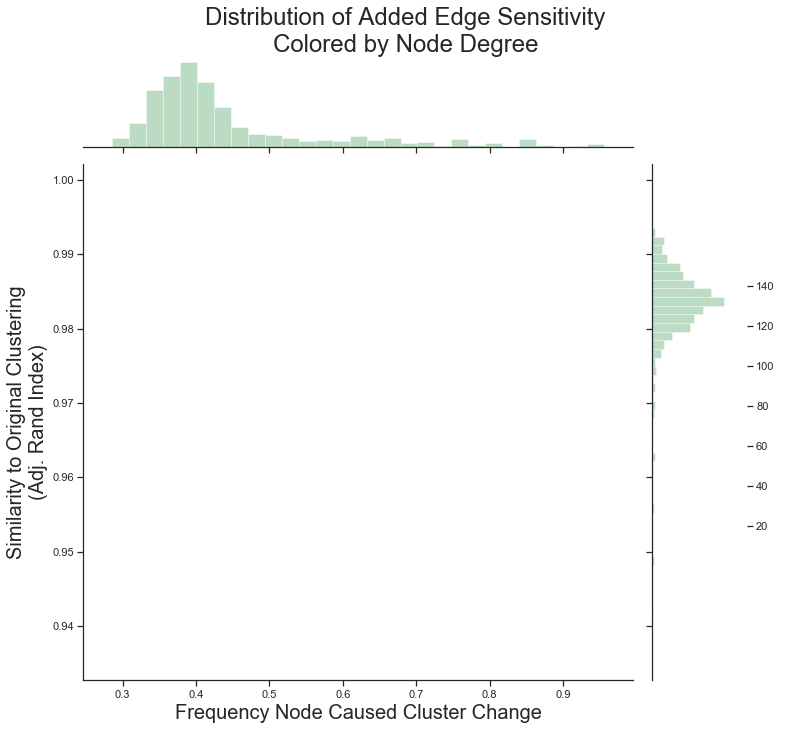

In [178]:
g = sns.jointplot(nonzero_count/517., mean_nonzero, color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., mean_nonzero, c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.outline.set_visible(False)
#cbar.ax.axes.set_visible(False)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20, color='white')

plt.show()

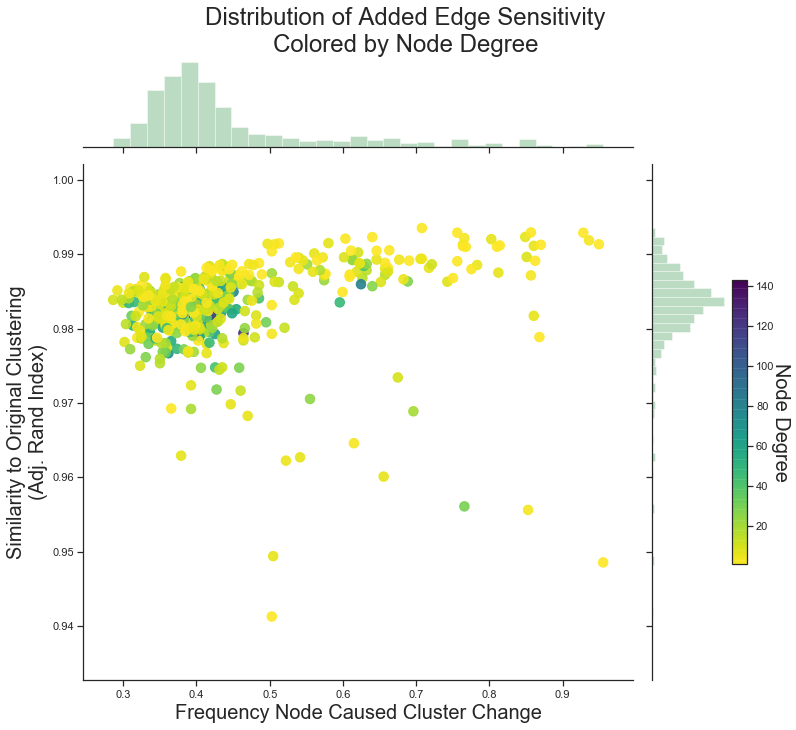

In [244]:
g = sns.jointplot(nonzero_count/517., mean_nonzero, color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., mean_nonzero, c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0.9, s=90)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20)

plt.show()

In [133]:
dark = pd.read_csv('../data/miscReference/dark_kinases.csv')
dark.head()

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [201]:
prgn = cm.get_cmap('PRGn')


In [187]:
import matplotlib.cm as cm

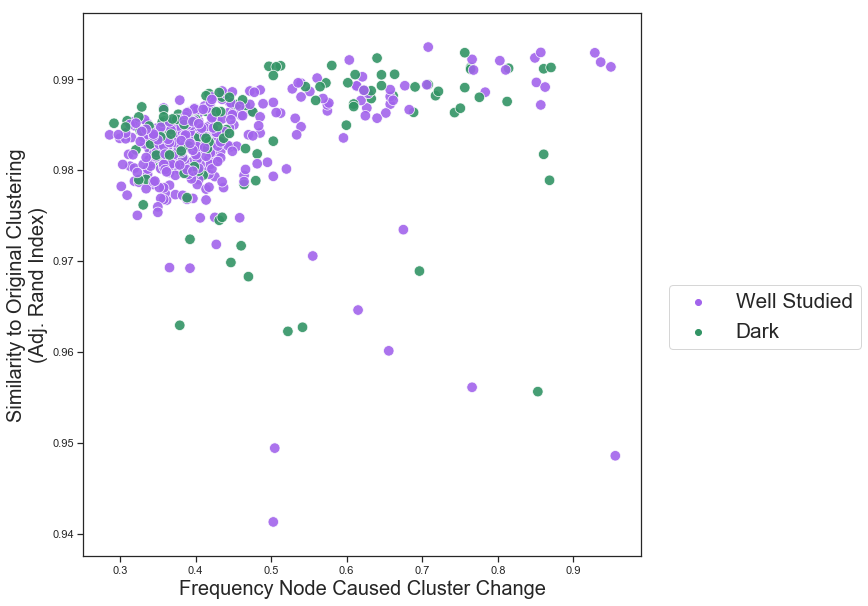

In [241]:
l = louv.merge(dark[['symbol', 'class']], left_index=True, right_on='symbol', how='left')
fig, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(nonzero_count/517., mean_nonzero, ax=ax, hue=(l['class'].fillna('Well Studied')).values, alpha=.9, s=110,
                   palette=sns.diverging_palette(280, 145, s=85, l=55, n=2))
g.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.set_xlabel('Frequency Node Caused Cluster Change', size=20)
 
#plt.setp(ax.get_legend().get_texts(), fontsize='26') 
#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, .5), loc=2, borderaxespad=0., fontsize='xx-large')
#sns.fig.legend
plt.show()

In [94]:
color = pd.read_csv('../results/networkClusters/louvain_clusters.txt', sep='\t')
color.head()

,names,cluster
0,MST1R,3
1,YES1,3
2,TYRO3,3
3,FGR,3
4,SRC,3


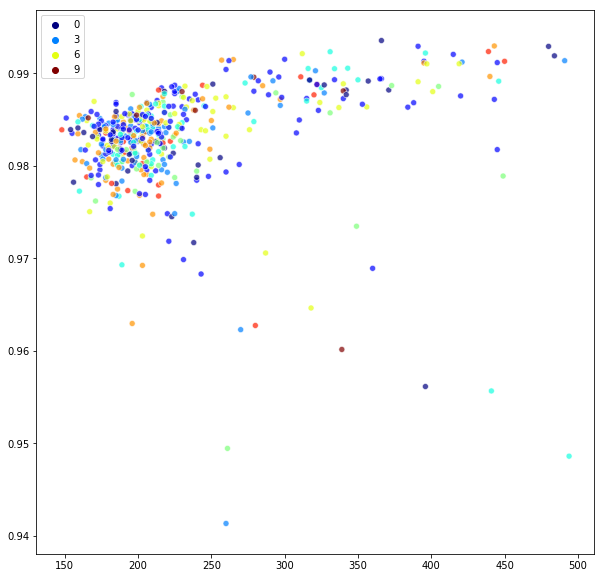

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(nonzero_count, mean_nonzero, ax=ax, hue=color['cluster'].values, palette='jet', alpha=0.7)
plt.show()